In [6]:
import gzip
import json

data = []
with gzip.open("data/dataset0.json.gz", "rt") as f:
    for line in f:
        data.append(json.loads(line))

In [7]:
data[1]

{'ENST00000000233': {'261': {'CAAACTG': [[0.0126,
     1.95,
     111.0,
     0.0125,
     1.27,
     108.0,
     0.00996,
     2.94,
     101.0],
    [0.00432, 2.35, 111.0, 0.00559, 2.4, 106.0, 0.00332, 1.39, 94.5],
    [0.00266, 3.81, 108.0, 0.00645, 3.59, 108.0, 0.00827, 2.12, 93.3],
    [0.00498, 2.79, 109.0, 0.0206, 3.68, 111.0, 0.00303, 6.33, 92.4],
    [0.00664, 2.68, 114.0, 0.0104, 2.22, 108.0, 0.00232, 5.59, 89.2],
    [0.00564, 3.19, 108.0, 0.0083, 8.05, 100.0, 0.00744, 2.17, 93.4],
    [0.00797, 2.86, 111.0, 0.00289, 3.25, 109.0, 0.00432, 2.86, 97.7],
    [0.00398, 2.56, 109.0, 0.00232, 2.73, 101.0, 0.0208, 3.22, 94.0],
    [0.0116, 2.42, 110.0, 0.0091, 3.22, 109.0, 0.0113, 2.53, 94.8],
    [0.00797, 4.86, 108.0, 0.00831, 3.07, 110.0, 0.00465, 1.76, 91.8],
    [0.0186, 4.31, 109.0, 0.00232, 1.94, 104.0, 0.0193, 3.1, 93.1],
    [0.00529, 2.68, 106.0, 0.00266, 0.789, 104.0, 0.00564, 3.81, 92.6],
    [0.0153, 17.0, 108.0, 0.00442, 3.06, 110.0, 0.00764, 2.37, 93.0],
    [0.00598

In [8]:
def get_id_and_position(data):
    id = list(data.keys())[0]
    position = list(data[id].keys())[0]
    return id, position

def get_features(data):
    id, position = get_id_and_position(data)
    return list(data[id][position].values())[0]

def get_rna_seq(data):
    id, position = get_id_and_position(data)
    return list(data[id][position].keys())[0]

# get_id_and_position(data[0])
# get_features(data[0])
get_rna_seq(data[0])

'AAGACCA'

In [9]:
rna_mapping = {
    'A': [1,0,0,0],
    'C': [0,1,0,0],
    'G': [0,0,1,0],
    'T': [0,0,0,1],
}

def get_mapped_rna(rna: str):
    result = []
    for i in rna:
        result.append(rna_mapping[i])
    return result

rna = get_rna_seq(data[0])
get_mapped_rna(rna)

[[1, 0, 0, 0],
 [1, 0, 0, 0],
 [0, 0, 1, 0],
 [1, 0, 0, 0],
 [0, 1, 0, 0],
 [0, 1, 0, 0],
 [1, 0, 0, 0]]

In [10]:
import numpy as np

feature_length = []
for i in data:
    feature_length.append(len(get_features(i)))

print(np.mean(feature_length))
print(f"minimum number of reads is {np.min(feature_length)}")

90.506295244505
minimum number of reads is 20


In [11]:
import pandas as pd

# Read the labelled info file
df_labels = pd.read_csv("data/data.info.labelled")

In [12]:
label_dict = {
    (row.transcript_id, row.transcript_position): row.label
    for row in df_labels.itertuples(index=False)
}

label_dict.get(("ENST00000000233", 244), None)


0

In [13]:
def aggregate_reads(reads):
    arr = np.array(reads)  # shape: (n_reads, 9)
    features = np.concatenate([
        arr.mean(axis=0),
        arr.std(axis=0),
        arr.min(axis=0),
        arr.max(axis=0),
        np.median(arr, axis=0),
    ])
    return features

In [14]:
entry = data[0]
id, position = get_id_and_position(entry)
features = get_features(entry)
X_numeric = aggregate_reads(features)
rna = get_rna_seq(entry)
rna_onehot = get_mapped_rna(rna)
rna_onehot = np.array(rna_onehot)
print(rna_onehot.shape)
X_seq_flat = rna_onehot.reshape(rna_onehot.shape[0], -1)  # shape: (N, 28)

X_seq_flat.shape

# X_combined = np.concatenate([X_numeric, rna_onehot], axis=1)

# X_combined

(7, 4)


(7, 4)

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = []
y = []

for entry in data:
    id, position = get_id_and_position(entry)
    features = get_features(entry)
    label = label_dict.get((id, int(position)), None)
    rna = get_rna_seq(entry)
    rna_matrix = np.array(get_mapped_rna(rna))
    rna_flattern = rna_matrix.flatten()
    combined = np.concatenate([aggregate_reads(features), rna_flattern])
    X.append(combined)
    y.append(label)

X = np.array(X)
y = np.array(y)

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

In [16]:
X.shape

(121838, 73)

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

model = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=5000, solver='lbfgs', class_weight='balanced')
)
model.fit(X_train, y_train)


,steps,"[('standardscaler', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


In [34]:
from sklearn.metrics import roc_auc_score

y_pred = model.predict_proba(X_val)[:, 1]
print("AUC:", roc_auc_score(y_val, y_pred))


AUC: 0.900327965311893


In [35]:
y_pred_proba = model.predict_proba(X_test)[:, 1]


In [36]:
from sklearn.metrics import roc_auc_score, average_precision_score

roc_auc = roc_auc_score(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba)

print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC:  {pr_auc:.4f}")

ROC AUC: 0.9044
PR AUC:  0.4016


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

RocCurveDisplay.from_predictions(y_test, y_pred_proba)
plt.title("ROC Curve")
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba)
plt.title("Precision–Recall Curve")
plt.show()


In [41]:
! pip install imbalanced-learn

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators=200,      # number of trees
    max_depth=None,        # let trees expand fully
    random_state=42,       # reproducibility
    class_weight='balanced' # good for imbalanced data
)

rf.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [49]:
! pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.0 MB/s  0:00:00 eta 0:00:01


In [ ]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='aucpr',
    scale_pos_weight=20,
    random_state=42
)

xgb_model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'aucpr'


Validation ROC AUC: 0.919
Validation PR AUC: 0.451
Test ROC AUC: 0.925
Test PR AUC: 0.482


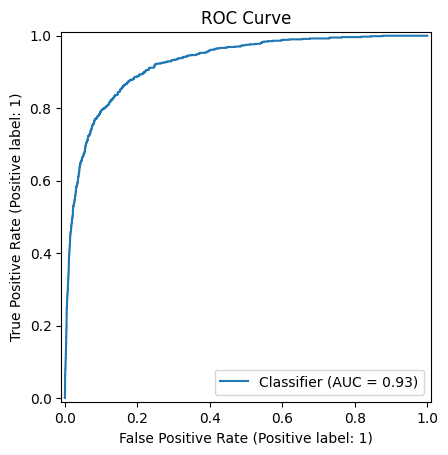

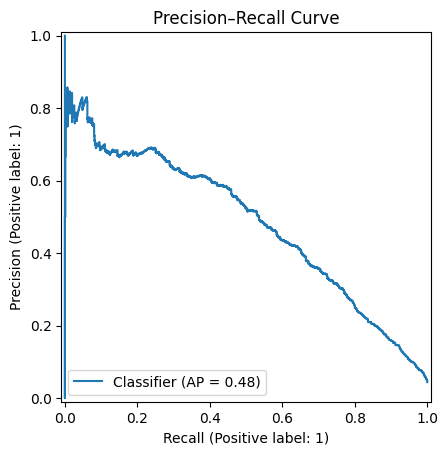

In [21]:
from sklearn.metrics import roc_auc_score, average_precision_score

# Predict probabilities for ROC and PR curve metrics
y_val_pred_proba = xgb_model.predict_proba(X_val)[:, 1]
y_test_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# ROC AUC
roc_auc_val = roc_auc_score(y_val, y_val_pred_proba)
roc_auc_test = roc_auc_score(y_test, y_test_pred_proba)

# PR AUC (Average Precision)
pr_auc_val = average_precision_score(y_val, y_val_pred_proba)
pr_auc_test = average_precision_score(y_test, y_test_pred_proba)

print(f"Validation ROC AUC: {roc_auc_val:.3f}")
print(f"Validation PR AUC: {pr_auc_val:.3f}")
print(f"Test ROC AUC: {roc_auc_test:.3f}")
print(f"Test PR AUC: {pr_auc_test:.3f}")

RocCurveDisplay.from_predictions(y_test, y_test_pred_proba)
plt.title("ROC Curve")
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_test_pred_proba)
plt.title("Precision–Recall Curve")
plt.show()

In [17]:
import os, json, gzip
import numpy as np
import xgboost as xgb
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, roc_auc_score

def parse_json_line(obj):
    (tid, tdata), = obj.items()
    (pos_key, contexts), = tdata.items()
    pos = int(pos_key) if isinstance(pos_key, str) else pos_key
    (ctx7, reads), = contexts.items()
    arr = np.asarray(reads, dtype=float)
    return tid, pos, ctx7, arr

BASE_IDX = {"A":0, "C":1, "G":2, "T":3}
def onehot28(seq7: str) -> np.ndarray:
    out = np.zeros((7,4), dtype=np.int8)
    s = (seq7 or "").upper()
    for i in range(min(7, len(s))):
        j = BASE_IDX.get(s[i], -1)
        if j >= 0:
            out[i, j] = 1
    return out.ravel()

def aggregate_9(arr: np.ndarray) -> np.ndarray:
    if arr.size == 0:
        return np.zeros(45, dtype=np.float32)
    mean = arr.mean(axis=0)
    std  = arr.std(axis=0, ddof=0)
    mn   = arr.min(axis=0)
    mx   = arr.max(axis=0)
    med  = np.median(arr, axis=0)
    return np.concatenate([mean, std, mn, mx, med]).astype(np.float32, copy=False)

NUM_COLS = [
    "dwell_m1","sd_m1","mean_m1",
    "dwell_0","sd_0","mean_0",
    "dwell_p1","sd_p1","mean_p1",
]
FEATURE_NAMES = (
    [f"mean_{c}"   for c in NUM_COLS] +
    [f"std_{c}"    for c in NUM_COLS] +
    [f"min_{c}"    for c in NUM_COLS] +
    [f"max_{c}"    for c in NUM_COLS] +
    [f"median_{c}" for c in NUM_COLS] +
    [f"ctx_{i}"    for i in range(28)]
)


def build_dataset_from_json_objects(json_objects, label_dict):
    """
    json_objects: iterable of parsed per-line dicts
    label_dict: {(transcript_id, position): 0/1}
    Returns X (N,73), y (N,), plus ids for later mapping.
    """
    X_rows, y_rows, ids = [], [], []
    for obj in json_objects:
        tid, pos, ctx7, arr = parse_json_line(obj)
        feats45 = aggregate_9(arr)
        ctx28   = onehot28(ctx7)
        X_rows.append(np.concatenate([feats45, ctx28]))
        y_rows.append(label_dict.get((tid, int(pos)), None))
        ids.append((tid, int(pos)))
    X = np.asarray(X_rows, dtype=np.float32)
    y = np.asarray(y_rows)
    return X, y, ids

def train_and_save_model(X, y, model_dir="models"):
    mask = ~pd.isna(y)
    X_tr = X[mask]; y_tr = y[mask].astype(int)

    X_train, X_temp, y_train, y_temp = train_test_split(X_tr, y_tr, test_size=0.3, random_state=42, stratify=y_tr)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

    clf = xgb.XGBClassifier(
        n_estimators=800,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="aucpr",
        scale_pos_weight=20,
        random_state=42,
        n_jobs=os.cpu_count(), 
    )
    clf.fit(X_train, y_train)

    val_p = clf.predict_proba(X_val)[:,1]
    tst_p = clf.predict_proba(X_test)[:,1]
    print("VAL  AUPRC:", average_precision_score(y_val, val_p), "AUROC:", roc_auc_score(y_val, val_p))
    print("TEST AUPRC:", average_precision_score(y_test, tst_p), "AUROC:", roc_auc_score(y_test, tst_p))

    Path(model_dir).mkdir(parents=True, exist_ok=True)
    clf.save_model(Path(model_dir) / "xgb_model.json")
    with open(Path(model_dir) / "metadata.json", "w") as f:
        json.dump({
            "feature_names": FEATURE_NAMES,
            "threshold": 0.5
        }, f, indent=2)
    return clf

def iter_json_lines(path: str):
    """Stream NDJSON from .json or .json.gz"""
    p = Path(path)
    if p.suffix == ".gz":
        with gzip.open(p, "rt", encoding="utf-8", errors="replace") as f:
            for line in f:
                s = line.strip()
                if s:
                    yield json.loads(s)
    else:
        with open(p, "r", encoding="utf-8") as f:
            for line in f:
                s = line.strip()
                if s:
                    yield json.loads(s)

In [18]:
df_labels = pd.read_csv("data/data.info.labelled")
label_dict = { (r.transcript_id, int(r.transcript_position)): int(r.label) for r in df_labels.itertuples(index=False) }

train_json_iter = iter_json_lines("data/dataset0.json.gz")
X, y, ids = build_dataset_from_json_objects(train_json_iter, label_dict)

model = train_and_save_model(X, y, model_dir="models")

VAL  AUPRC: 0.47670753441563174 AUROC: 0.9256057702735894
TEST AUPRC: 0.5043254344417619 AUROC: 0.9220049049042415


In [19]:
X.shape

(121838, 73)